In [ ]:
from dask.distributed import Client

client = Client("tcp://145.136.63.18:35245")
client

In [1]:
import os

# Set the MALLOC_TRIM_THRESHOLD_ environment variable
os.environ['MALLOC_TRIM_THRESHOLD_'] = '0'

# Run your Dask script or notebook
...


Ellipsis

In [2]:
from dask.distributed import Client

client = Client(n_workers=4, threads_per_worker=1)
client

/home/qiahan/.conda/envs/mamba/envs/emulator/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36169 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/36169/status,
Dashboard: /proxy/36169/status,Workers: 4
Total threads: 4,Total memory: 240.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36905,Workers: 4
Dashboard: /proxy/36169/status,Total threads: 4
Started: Just now,Total memory: 240.00 GiB
Comm: tcp://127.0.0.1:45819,Total threads: 1
Dashboard: /proxy/45055/status,Memory: 60.00 GiB
Nanny: tcp://127.0.0.1:33861,


In [3]:
"""
Thesis_PhD_Qianqian Predicted_fluxes_glboal_stripes
date: 24-Feb-2023
author: Qianqian
Contact: q.han@utwente.nl
-------------------------------------
Description: 
"""
# libraries
import os
import joblib
from osgeo import gdal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.warp import reproject, Resampling
import xarray as xr
import pickle
from PyStemmusScope import variable_conversion as vc
from rasterio.warp import reproject, Resampling
from sklearn.preprocessing import OneHotEncoder
import time
import os
import re
import glob
import rioxarray
import dask.array

In [4]:
# load trained RF model, better use not parallel model with Dask
with open('/gpfs/work1/0/einf2480/global_data_Qianqian/RF_train/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi7_1core_snellius0629.pkl', 'rb') as f:
    rfLEHmulti = pickle.load(f)

In [5]:
# # load trained RF model
# with open('/data/private/DL/Kratzert/10kmfluxes/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi2.pkl', 'rb') as f:
#     rfLEHmulti_parallel = pickle.load(f)

## define function to read file

In [6]:
import os
import re

def get_directories_with_number_and_ending(directory_path, ending):
    directories = []
    if ending:
        pattern = re.compile(r'^\d+.*{}$'.format(re.escape(ending)))  # Match directory names with number at the beginning and specific ending
    else:
        pattern = re.compile(r'^\d+$')  # Match directory names with only numbers

    for entry in os.scandir(directory_path):
        if entry.is_dir():
            directory_name = entry.name
            if pattern.match(directory_name):
                directories.append(directory_name)

    return directories


In [7]:
def Read_LSFs_Estimated_fluxes(year_id, model):
    # get all the filefolders named as year
    year_list = get_directories_with_number_and_ending("/data/private/DL/datadownload/", "")
    # the input data from year[0] to year[..], based on the process id in sbatch script
    year = year_list[year_id-1]
    print(type(year))
    # reference file for spatial resample
    t = '2011-03-01T00:00:00.000000000'
    era5 = xr.open_dataset("/data/private/DL/datadownload/"+year+'/era5land/era5-land_10m_u_component_of_wind_2011-03_FI-Hyy.nc').sel(time=t, method='nearest')['u10']
    
    starttime0 = time.time()
    ### 0) read era5land data
    all1 = xr.open_mfdataset("/data/private/DL/datadownload/"+year+"/era5land/*.nc")
    all_resample = all1.resample(time="1800S").interpolate('linear')
    # 累减得到每小时的辐射
    Rin = all1.to_array()[2,:,:,:].copy().astype(float)
    Rin[::] = np.nan
    Rli = all1.to_array()[3,:,:,:].copy().astype(float)
    Rli[::] = np.nan
    for count_i,t in zip(range(745), all1.time.to_numpy()):
        ds_era5land0 = all1.sel(time=np.datetime64(t)- np.timedelta64(1,'h'), method='nearest').compute()
        ds_era5land = all1.sel(time=t, method='nearest').compute()
        ds0 = xr.merge([ds_era5land0])
        ds = xr.merge([ds_era5land])

        ds_ss = xr.Dataset()
        if (pd.to_datetime(t).hour==1):
            # print(t)
            ds_ss["Rin"] = (ds["ssrd"]) / 3600  # J * hr / m2 ->  W / m2
            ds_ss["Rli"] = (ds["strd"]) / 3600  # J * hr / m2 ->  W / m2
        else:
            ds_ss["Rin"] = (ds["ssrd"]-ds0['ssrd']) / 3600  # J * hr / m2 ->  W / m2
            ds_ss["Rli"] = (ds["strd"]-ds0['strd']) / 3600  # J * hr / m2 ->  W / m2
        Rin[count_i,:,:] = ds_ss["Rin"]
        Rli[count_i,:,:] = ds_ss["Rli"]
    #对辐射进行线性插值到半小时
    Rin = Rin.resample(time="1800S").interpolate('linear')
    Rli = Rli.resample(time="1800S").interpolate('linear')
    
    
    ### 1) read LAI data
    probav_files = sorted(Path("/data/private/DL/datadownload/"+year+"/lai/").glob("*201103*.nc"))
    lai_10km = []
    for i in probav_files:
        lai0 = xr.open_dataset(i)["LAI"].sel(lat=slice(65, 60), lon=slice(20, 25))
        # print(lai.values)

        lai0 = lai0.rio.write_crs('EPSG:4326')
        era5 = era5.rio.write_crs('EPSG:4326')
        lai0.rio.write_nodata(lai0.rio.nodata, inplace=True)
        #好像不能同时重采样多个波段，不然nan值会互相影响。从python导出的LAI，然后在ArcGIS打开看着一样，但是在python里面，non-nan值的个数却不一样。
        lai0_10km = lai0.rio.reproject_match(era5, resampling=Resampling.average)
        lai0_10km = lai0_10km.assign_coords({
            "x": lai0_10km.x,
            "y": lai0_10km.y,
        })
        lai_10km.append(lai0_10km)
    lai = xr.concat(lai_10km, dim='time').resample(time="1800S").interpolate('linear').rename({'x':'longitude','y':'latitude'})
    
    
    ### 2) read canopy height data
    hc_path = '/data/private/DL/datadownload/'+year+'/canopy_height/output/mosaic_output10km.tif'
    hc = xr.open_dataset(hc_path, engine="rasterio").rename({'x':'longitude','y':'latitude'}).band_data
    
    
    ### 3) read CO2 data
    ds_co2 = xr.open_mfdataset("/data/private/DL/datadownload/"+year+"/co2/CAMS_CO2_2011*.nc")['co2'].sel(time='2011-03')#.sel(latitude=slice(65, 60), longitude=slice(20, 25))
    # convert unit: kg/kg to mg/m3
    ds_co2 = vc.co2_mass_fraction_to_kg_per_m3(ds_co2)*1e6
    # convert the longitude from [0, 360] to [-180, 180]
    lon_name = 'longitude'
    ds_co2['longitude_adjusted'] = xr.where(
        ds_co2[lon_name] > 180,
        ds_co2[lon_name] - 360,
        ds_co2[lon_name])
    ds_co2 = (
        ds_co2
        .swap_dims({lon_name: 'longitude_adjusted'})
        .sel(**{'longitude_adjusted': sorted(ds_co2.longitude_adjusted)})
        .drop(lon_name))
    ds_co2 = ds_co2.rename({'longitude_adjusted': lon_name})
    ds_co2 = ds_co2.rio.write_crs('EPSG:4326')
    era5 = era5.rio.write_crs('EPSG:4326')
    ds_co2.rio.write_nodata(ds_co2.rio.nodata, inplace=True)
    ds_co2_10km = ds_co2.rio.reproject_match(era5, resampling=Resampling.average)
    ds_co2_10km = ds_co2_10km.assign_coords({
        "x": ds_co2_10km.x,
        "y": ds_co2_10km.y,
    })
    ds_co2_10km = ds_co2_10km.resample(time="1800S").interpolate('linear').rename({'x':'longitude','y':'latitude'})
    #CO2有1483个波段，ERA5-Land有1487个波段。一个到21点，一个到23点。
    #值得注意的是ERA5-Land的时间是每个step的结束时间，而CO2是每个step的开始时间？
    #2011-03-01T00:30:00.000000000 在ERA5-Land代表的是00:00-00:30，而在CO2代表00:30-01:00？
    ds_co2_10km=ds_co2_10km.assign_coords({'time':('time',ds_co2_10km.time.values + np.timedelta64(30,'m'),ds_co2_10km.time.attrs)})
    #https://stackoverflow.com/questions/64737439/xarray-dataset-change-value-of-coordinates-while-keeping-attributes
    
    
    ### 4) read SSM data
    path_SSM = "/data/private/DL/datadownload/"+year+"/ssm/SM2011Europe1kmfluxTest-0000000000-0000000000.tif"
    ds_SSM = xr.open_rasterio(path_SSM, engine="rasterio")
    ds_SSM = ds_SSM.sortby(["x", "y"])
    ds_SSM = ds_SSM.sel(x=slice(20,25), y=slice(60, 65))
    ds_SSM['band'] = pd.to_datetime(ds_SSM.band-1, unit='D', origin=str(path_SSM.split('/')[-1][2:6]))
    ds_SSM = ds_SSM.rename({'band':'time'})
    SSM_10km = []
    for i in ds_SSM.time[59:90]:
        SSM0 = ds_SSM.sel(time=i)
        SSM0 = SSM0.rio.write_crs('EPSG:4326')
        era5 = era5.rio.write_crs('EPSG:4326')
        SSM0.rio.write_nodata(SSM0.rio.nodata, inplace=True)
        #好像不能同时重采样多个波段，不然nan值会互相影响。从python导出的LAI，然后在ArcGIS打开看着一样，但是在python里面，non-nan值的个数却不一样。
        SSM0_10km = SSM0.rio.reproject_match(era5, resampling=Resampling.average, nodata=np.nan) #
        SSM0_10km = SSM0_10km.assign_coords({
            "x": SSM0_10km.x,
            "y": SSM0_10km.y,
        })
        SSM_10km.append(SSM0_10km)
    SSM = xr.concat(SSM_10km, dim='time').resample(time="1800S").interpolate('linear').rename({'x':'longitude','y':'latitude'})/1000 
    
    
    ### 5) read Vcmax data
    ds_Vcmo = xr.open_rasterio("/data/private/DL/datadownload/"+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km.tif", engine="rasterio")
    
    
    ### 6) read IGBP data
    path_landcover = "/data/private/DL/datadownload/"+year+"/igbp/landcover10km.tif"
    landcover = xr.open_rasterio(path_landcover, engine="rasterio")
    FILEPATH_LANDCOVER_TABLE = "/data/private/DL/datadownload/"+year+"/igbp/lccs_to_igbp_table.csv"
    IGBP_table = pd.read_csv(FILEPATH_LANDCOVER_TABLE)
    IGBP = np.vectorize(IGBP_table.set_index("lccs_class").T.to_dict('records')[0].get)(landcover.values)
    training_testing_append = pd.read_csv('/data/private/DL/Kratzert/emulator/training_testing-withindex_v2.csv')
    IGBP_all = pd.DataFrame(columns=['IGBP_veg_long1', 'IGBP_veg_long2', 'IGBP_veg_long3','IGBP_veg_long4','IGBP_veg_long5',
                              'IGBP_veg_long6','IGBP_veg_long7','IGBP_veg_long8','IGBP_veg_long9',
                             'IGBP_veg_long10','IGBP_veg_long11'])
    # define one hot encoding for IGBP
    encoder = OneHotEncoder(categories=[training_testing_append['IGBP_veg_long'].unique()]*1,sparse=False,
                           handle_unknown = "ignore")
    # transform data
    aa = encoder.fit_transform(IGBP.reshape(IGBP.shape[1]*IGBP.shape[1],1))
    # assign 23-D IGBP into 23 columns
    for i in range(1,12,1):
        IGBP_all['IGBP_veg_long'+str(i)] = aa[:,i-1]
    
    print('read data, That took {} seconds'.format(time.time() - starttime0))     
    ### end) combine predictor variables and predict
    result_LE = all_resample.to_array()[0,:,:,:].copy().astype(float)
    result_LE[::] = np.nan
    result_H = all_resample.to_array()[0,:,:,:].copy().astype(float)
    result_H[::] = np.nan
    #static predictors
    hc_line = hc[0,:,:].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size) #如果和动态变量一样放进ds_ss里显示为一些离散的点，不知道为什么，所以静态变量放在时间循环外面
    Vcmo_line = ds_Vcmo[0,:,:].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP1 = IGBP_all.iloc[:,0].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP2 = IGBP_all.iloc[:,1].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP3 = IGBP_all.iloc[:,2].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP4 = IGBP_all.iloc[:,3].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP5 = IGBP_all.iloc[:,4].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP6 = IGBP_all.iloc[:,5].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP7 = IGBP_all.iloc[:,6].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP8 = IGBP_all.iloc[:,7].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP9 = IGBP_all.iloc[:,8].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP10 = IGBP_all.iloc[:,9].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP11 = IGBP_all.iloc[:,10].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    
    starttime = time.time()

    for count_i,t in enumerate(all_resample.time.to_numpy()[500:504]):#zip(range(100), all_resample.time.to_numpy()[500:502]): #
        print(t)
        starttime1 = time.time()
        ds_era5land = all_resample.sel(time=t, method='nearest').compute()
        ds = xr.merge([ds_era5land])
        ds_ss = xr.Dataset()
        ds_ss["Rin"] = Rin.sel(time=t, method='nearest').compute()
        ds_ss["Rli"] = Rli.sel(time=t, method='nearest').compute()
        ds_ss["p"] = ds["sp"]/100   # Pa -> hPa
        ds_ss["Ta"] = ds["t2m"] - 273.15  # K -> degC
        ds_ss["ea"] = vc.calculate_es(ds["d2m"] - 273.15)
        ds_ss["u"] = (ds["u10"] ** 2 + ds["v10"] ** 2) ** 0.5
        ds_ss["Precip_msr"] = ds["tp"]*1000   # mm
        ds_ss['LAI'] = lai.sel(time=t, method='nearest').compute()
        ds_ss['CO2'] = ds_co2_10km.sel(time=t, method='nearest').compute()
        ds_ss['SSM'] = SSM.sel(time=t, method='nearest').compute()

        ds_ss = ds_ss.to_array()
        Rin_line = ds_ss[0,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
        Rli_line = ds_ss[1,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
        p_line = ds_ss[2,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
        Ta_line = ds_ss[3,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
        ea_line = ds_ss[4,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
        u_line = ds_ss[5,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
        Precip_msr_line = ds_ss[6,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
        LAI_line = ds_ss[7,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
        CO2_line = ds_ss[8,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
        SSM_line = ds_ss[9,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)

        features_arr = np.concatenate((Rin_line, Rli_line, p_line, Ta_line,ea_line, u_line, Precip_msr_line,
                                       LAI_line, hc_line, CO2_line, SSM_line, Vcmo_line,
                                       IGBP1, IGBP2, IGBP3,IGBP4,IGBP5,IGBP6,IGBP7,IGBP8,IGBP9,IGBP10,IGBP11))
        features_arr = features_arr.transpose()
        print(type(features_arr))

        # Nan value.
        df_features = pd.DataFrame(data=features_arr)
        df_features_drop_nan = df_features.dropna()
        invalid_index = sorted(set(df_features.index.to_list()) - set(df_features_drop_nan.index.to_list()))

        # # Convert the nan value as 0 for the calculation
        where_are_NaNs = np.isnan(features_arr)
        features_arr[where_are_NaNs] = 0
        print('input data orgainze took {} seconds'.format(time.time() - starttime1))  
        starttime2 = time.time()
        
        estimated_LEH = model.predict(features_arr)
        estimated_LEH[invalid_index] = np.nan
        LEH_map = estimated_LEH.reshape(ds_ss.latitude.size, ds_ss.longitude.size,2)
        print('1 timestep took {} seconds'.format(time.time() - starttime2))  
        starttime3 = time.time()
        result_LE[count_i, ::] = LEH_map[:,:,0]
        result_H[count_i, ::] = LEH_map[:,:,1]
        print('assign values took {} seconds'.format(time.time() - starttime3))  
    # # export the result
    # result_LE.rio.write_crs('EPSG:4326').rio.to_raster(
    #     '/data/private/DL/datadownload/output/LE.tif',
    #     tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
    #     windowed=True,  # rioxarray: read & write one window at a time
    # )
    # result_H.rio.write_crs('EPSG:4326').rio.to_raster(
    #     '/data/private/DL/datadownload/output/H.tif',
    #     tiled=True,  # GDAL: By default striped TIFF files are created. This option can be used to force creation of tiled TIFF files.
    #     windowed=True,  # rioxarray: read & write one window at a time
    # )
    
    print('That took {} seconds'.format(time.time() - starttime))     
    return result_LE, result_H

In [8]:
inputPath = "/gpfs/work1/0/einf2480/global_data_Qianqian/"

In [9]:
# get all the filefolders named as year
year_list = get_directories_with_number_and_ending(inputPath, "NL")
# the input data from year[0] to year[..], based on the process id in sbatch script
year = year_list[3-1]
print(year)
# reference file for spatial resample
t = '2011-03-01T00:00:00.000000000'
era5 = xr.open_dataset(inputPath+"/2017NL/era5land/era5-land_10m_u_component_of_wind_2017-01_FI-Hyy.nc")#.sel(time=t, method='nearest')['u10']
# print(era5)
starttime0 = time.time()
### 0) read era5land data
all1 = xr.open_mfdataset(inputPath+year+"/era5land/*.nc", chunks="auto")  # <- add the chunk size
 
all_resample = all1.resample(time="1800S").interpolate('linear')
all_resample = all_resample.isel(time=slice(0,2000))
# # 累减得到每小时的辐射
# Rin = all1.to_array()[2,:,:,:].copy().astype(float)
# Rin[:] = np.nan
# Rli = all1.to_array()[3,:,:,:].copy().astype(float)
# Rli[::] = np.nan
# for count_i,t in zip(range(745), all1.time.to_numpy()):
#     ds0 = all1.sel(time=np.datetime64(t)- np.timedelta64(1,'h'), method='nearest').compute()
#     ds = all1.sel(time=t, method='nearest').compute()
#     # ds0 = xr.merge([ds_era5land0])
#     # ds = xr.merge([ds_era5land])
    
#     ds_ss = xr.Dataset()
#     if (pd.to_datetime(t).hour==1):
#         # print(t)
#         ds_ss["Rin"] = (ds["ssrd"]) / 3600  # J * hr / m2 ->  W / m2
#         ds_ss["Rli"] = (ds["strd"]) / 3600  # J * hr / m2 ->  W / m2
        
#     else:
#         ds_ss["Rin"] = (ds["ssrd"]-ds0['ssrd']) / 3600  # J * hr / m2 ->  W / m2
#         ds_ss["Rli"] = (ds["strd"]-ds0['strd']) / 3600  # J * hr / m2 ->  W / m2
#     Rin[count_i,:,:] = ds_ss["Rin"]
#     Rli[count_i,:,:] = ds_ss["Rli"]
    
# # #对辐射进行线性插值到半小时
# # Rin = Rin.resample(time="1800S").interpolate('linear')
# # Rli = Rli.resample(time="1800S").interpolate('linear')


2017NL


In [10]:
all_resample

<xarray.Dataset>
Dimensions:    (longitude: 51, latitude: 51, time: 2000)
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * time       (time) datetime64[ns] 2017-01-01 ... 2017-02-11T15:30:00
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-08 17:23:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [11]:
Rin = all1['ssrd'].diff("time")/3600  #xr.concat([all1['ssrd'].isel(time=0),all1['ssrd']], dim="time")
Rin[0::24] = all1['ssrd'][1::24].values/3600 # assign the original values in t01
# Rin.mean(dim=['longitude','latitude']).compute()[48]
Rli = all1['strd'].diff("time")/3600  
Rli[0::24] = all1['strd'][1::24].values/3600
# Rli.mean(dim=['longitude','latitude']).plot()
Rin = Rin.resample(time="1800S").interpolate('linear')
Rli = Rli.resample(time="1800S").interpolate('linear')
Rin

<xarray.DataArray 'ssrd' (time: 17517, latitude: 51, longitude: 51)>
dask.array<transpose, shape=(17517, 51, 51), dtype=float32, chunksize=(17517, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * time       (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-12-31T23:00:00

In [12]:
### 1) read LAI data
probav_files = sorted(Path(inputPath+year+"/lai/").glob("*.nc"))
lai_10km = []
for i in probav_files:
    lai0 = xr.open_dataset(i)["LAI"].sel(lat=slice(55, 50), lon=slice(2, 7))
    # print(lai.values)

    lai0 = lai0.rio.write_crs('EPSG:4326')
    era5 = era5.rio.write_crs('EPSG:4326')
    lai0.rio.write_nodata(lai0.rio.nodata, inplace=True)
    #好像不能同时重采样多个波段，不然nan值会互相影响。从python导出的LAI，然后在ArcGIS打开看着一样，但是在python里面，non-nan值的个数却不一样。
    lai0_10km = lai0.rio.reproject_match(era5, resampling=Resampling.average)
    lai0_10km = lai0_10km.assign_coords({
        "x": lai0_10km.x,
        "y": lai0_10km.y,
    })
    lai_10km.append(lai0_10km)
lai = xr.concat(lai_10km, dim='time').resample(time="1800S").interpolate('linear').rename({'x':'longitude','y':'latitude'})
lai = lai.isel(time=slice(0,2000))

In [13]:
### 2) read canopy height data
hc_path = inputPath+year+'/canopy_height/mosaic_output10km.tif'
hc = xr.open_dataset(hc_path, engine="rasterio").rename({'x':'longitude','y':'latitude'}).band_data

In [14]:
### 3) read CO2 data
ds_co2 = xr.open_mfdataset(inputPath+year+"/co2/CAMS_CO2_20*.nc", chunks="auto")['co2'].sel(time=year[:-2]).sel(latitude=slice(55, 50), longitude=slice(2, 7))
# convert unit: kg/kg to mg/m3
ds_co2 = vc.co2_mass_fraction_to_kg_per_m3(ds_co2)*1e6
# convert the longitude from [0, 360] to [-180, 180]
lon_name = 'longitude'
ds_co2['longitude_adjusted'] = xr.where(
    ds_co2[lon_name] > 180,
    ds_co2[lon_name] - 360,
    ds_co2[lon_name])
ds_co2 = (
    ds_co2
    .swap_dims({lon_name: 'longitude_adjusted'})
    .sel(**{'longitude_adjusted': sorted(ds_co2.longitude_adjusted)})
    .drop(lon_name))
ds_co2 = ds_co2.rename({'longitude_adjusted': lon_name})
ds_co2 = ds_co2.rio.write_crs('EPSG:4326')
era5 = era5.rio.write_crs('EPSG:4326')
ds_co2.rio.write_nodata(ds_co2.rio.nodata, inplace=True)

<xarray.DataArray 'co2' (time: 2920, latitude: 7, longitude: 7)>
dask.array<mul, shape=(2920, 7, 7), dtype=float32, chunksize=(2920, 7, 7), chunktype=numpy.ndarray>
Coordinates:
  * latitude     (latitude) float32 54.75 54.0 53.25 52.5 51.75 51.0 50.25
  * time         (time) datetime64[ns] 2017-01-01 ... 2017-12-31T21:00:00
  * longitude    (longitude) float32 2.25 3.0 3.75 4.5 5.25 6.0 6.75
    spatial_ref  int64 0

In [15]:
ds_co2_10km = ds_co2.rio.reproject_match(era5, resampling=Resampling.average)
ds_co2_10km = ds_co2_10km.assign_coords({
    "x": ds_co2_10km.x,
    "y": ds_co2_10km.y,
})
ds_co2_10km = ds_co2_10km.resample(time="1800S").interpolate('linear').rename({'x':'longitude','y':'latitude'})
#CO2有1483个波段，ERA5-Land有1487个波段。一个到21点，一个到23点。
#值得注意的是ERA5-Land的时间是每个step的结束时间，而CO2是每个step的开始时间？
#2011-03-01T00:30:00.000000000 在ERA5-Land代表的是00:00-00:30，而在CO2代表00:30-01:00？
ds_co2_10km=ds_co2_10km.assign_coords({'time':('time',ds_co2_10km.time.values + np.timedelta64(30,'m'),ds_co2_10km.time.attrs)})
#https://stackoverflow.com/questions/64737439/xarray-dataset-change-value-of-coordinates-while-keeping-attributes
ds_co2_10km = ds_co2_10km.isel(time=slice(0,2000))

In [16]:
### 4) read SSM data
path_SSM = glob.glob(inputPath+year+"/ssm/SM201*.tif")[0]
ds_SSM = xr.open_rasterio(path_SSM, engine="rasterio")
ds_SSM = ds_SSM.sortby(["x", "y"])
ds_SSM = ds_SSM.sel(x=slice(2,7), y=slice(50, 55))
ds_SSM['band'] = pd.to_datetime(ds_SSM.band-1, unit='D', origin=str(path_SSM.split('/')[-1][2:6]))
ds_SSM = ds_SSM.rename({'band':'time'})
SSM_10km = []
for i in ds_SSM.time[0:31]:
    SSM0 = ds_SSM.sel(time=i)
    SSM0 = SSM0.rio.write_crs('EPSG:4326')
    era5 = era5.rio.write_crs('EPSG:4326')
    SSM0.rio.write_nodata(SSM0.rio.nodata, inplace=True)
    #好像不能同时重采样多个波段，不然nan值会互相影响。从python导出的LAI，然后在ArcGIS打开看着一样，但是在python里面，non-nan值的个数却不一样。
    SSM0_10km = SSM0.rio.reproject_match(era5, resampling=Resampling.average, nodata=np.nan) #
    SSM0_10km = SSM0_10km.assign_coords({
        "x": SSM0_10km.x,
        "y": SSM0_10km.y,
    })
    SSM_10km.append(SSM0_10km)
SSM = xr.concat(SSM_10km, dim='time').resample(time="1800S").interpolate('linear').rename({'x':'longitude','y':'latitude'})/1000 
SSM = SSM.isel(time=slice(0,2000))


/scratch-local/qiahan.3006585/ipykernel_1812022/1780526371.py:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_SSM = xr.open_rasterio(path_SSM, engine="rasterio")


In [17]:
### 5) read Vcmax data
ds_Vcmo = xr.open_rasterio(inputPath+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km.tif", engine="rasterio").rename({'x':'longitude','y':'latitude'})

/scratch-local/qiahan.3006585/ipykernel_1812022/2490202976.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_Vcmo = xr.open_rasterio(inputPath+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km.tif", engine="rasterio").rename({'x':'longitude','y':'latitude'})


In [18]:
training_testing_append = pd.read_csv(inputPath+'RF_train/training_testing-withindex_v3.csv')

/scratch-local/qiahan.3006585/ipykernel_1812022/1454468402.py:1: DtypeWarning: Columns (80) have mixed types. Specify dtype option on import or set low_memory=False.
  training_testing_append = pd.read_csv(inputPath+'RF_train/training_testing-withindex_v3.csv')


In [19]:
def load_model(path):
    # load trained RF model, better use not parallel model with Dask
    with open(path, 'rb') as f:
        rfLEHmulti = pickle.load(f)
    return rfLEHmulti
def read_data(path):
    training_testing_append = pd.read_csv(path)
    return training_testing_append


In [20]:
data = training_testing_append["IGBP_veg_long"].unique()

In [21]:
FILEPATH_LANDCOVER_TABLE = inputPath+year+"/igbp/lccs_to_igbp_table.csv"
IGBP_table = pd.read_csv(FILEPATH_LANDCOVER_TABLE)

In [22]:
### 6) read IGBP data
path_landcover = inputPath+year+"/igbp/landcover10km.tif"
landcover = xr.open_rasterio(path_landcover, engine="rasterio", chunks="auto")

/scratch-local/qiahan.3006585/ipykernel_1812022/359658741.py:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  landcover = xr.open_rasterio(path_landcover, engine="rasterio", chunks="auto")


In [23]:
def landcover_to_igbp(landcover, IGBP_table, data):
    IGBP = np.vectorize(IGBP_table.set_index("lccs_class").T.to_dict('records')[0].get)(landcover.values)
    IGBP_all = pd.DataFrame(columns=['IGBP_veg_long1', 'IGBP_veg_long2', 'IGBP_veg_long3','IGBP_veg_long4','IGBP_veg_long5',
                              'IGBP_veg_long6','IGBP_veg_long7','IGBP_veg_long8','IGBP_veg_long9',
                             'IGBP_veg_long10','IGBP_veg_long11'])
    # define one hot encoding for IGBP
    encoder = OneHotEncoder(categories=[data]*1,sparse=False,
                           handle_unknown = "ignore")
    # transform data
    aa = encoder.fit_transform(IGBP.reshape(IGBP.shape[1]*IGBP.shape[1],1))
    # assign 23-D IGBP into 23 columns
    for i in range(1,12,1):
        IGBP_all['IGBP_veg_long'+str(i)] = aa[:,i-1]
    return IGBP_all

In [24]:
all_resample

<xarray.Dataset>
Dimensions:    (longitude: 51, latitude: 51, time: 2000)
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * time       (time) datetime64[ns] 2017-01-01 ... 2017-02-11T15:30:00
Data variables:
    d2m        (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    sp         (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    ssrd       (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    strd       (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    t2m        (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-08 17:23:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [25]:
Rin

<xarray.DataArray 'ssrd' (time: 17517, latitude: 51, longitude: 51)>
dask.array<transpose, shape=(17517, 51, 51), dtype=float32, chunksize=(17517, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude   (latitude) float32 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * time       (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-12-31T23:00:00

In [26]:
ds_era5land = all_resample#.sel(time=t, method='nearest')#.compute()

ds_ss = xr.Dataset()
ds_ss["Rin"] = Rin.isel(time=slice(0,2000))#.sel(time=t, method='nearest')#.compute()
ds_ss["Rli"] = Rli.isel(time=slice(0,2000))#.sel(time=t, method='nearest')#.compute()
ds_ss["p"] = all_resample["sp"]/100   # Pa -> hPa
ds_ss["Ta"] = all_resample["t2m"] - 273.15  # K -> degC
ds_ss["ea"] = vc.calculate_es(all_resample["d2m"] - 273.15)
ds_ss["u"] = (all_resample["u10"] ** 2 + all_resample["v10"] ** 2) ** 0.5
ds_ss["Precip_msr"] = all_resample["tp"]*1000   # mm
ds_ss['LAI'] = lai.chunk()#.sel(time=t, method='nearest')#.compute()
ds_ss['CO2'] = ds_co2_10km.chunk()#.sel(time=t, method='nearest')#.compute()
ds_ss['SSM'] = SSM.chunk()#.sel(time=t, method='nearest')#.compute()

ds_ss = ds_ss.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})
ds_Vcmo = ds_Vcmo.assign_coords({"longitude": hc.longitude.values, "latitude": hc.latitude.values})



# ds_ss = ds_ss.isel(time=slice(0,100))


In [27]:
ds_ss

<xarray.Dataset>
Dimensions:      (longitude: 51, latitude: 51, time: 2000)
Coordinates:
  * longitude    (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude     (latitude) float64 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * time         (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-02-11T16:...
    crs          int64 0
    spatial_ref  int64 0
Data variables:
    Rin          (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    Rli          (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    p            (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    Ta           (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    ea           (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    u            (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    Precip_msr   (time, latitude, longitude) float32 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    LAI          (time, latitude, longitude) float64 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    CO2          (time, latitude, longitude) float64 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>
    SSM          (time, latitude, longitude) float64 dask.array<chunksize=(2000, 51, 51), meta=np.ndarray>

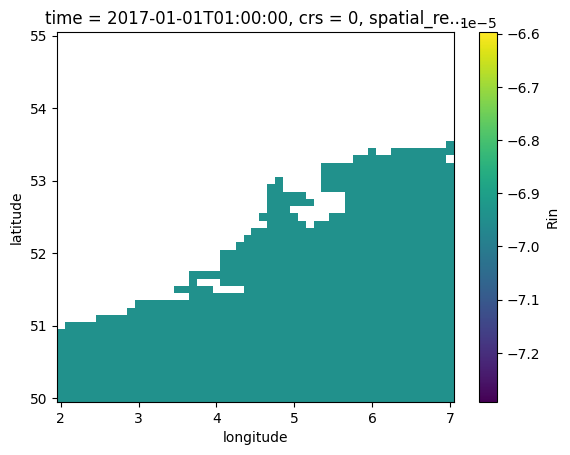

In [33]:
ds_ss['Rin'][0,:].plot()

In [67]:
estimated_LEH = xr.DataArray(
    data=dask.array.zeros((len(ds_ss.latitude), len(ds_ss.longitude),7, len(ds_ss.time)), chunks=(len(ds_ss.latitude), len(ds_ss.longitude),7, 1)),
    dims=("latitude", "longitude","variable_out", "time"),
    coords={
        "variable_out":range(7), 
        "time":ds_ss.time, 
        "latitude":ds_ss.latitude,
        "longitude":ds_ss.longitude
    }
)

In [68]:
def predictFlux(ds_ss, hc, ds_Vcmo, landcover, IGBP_table, training_testing_append, path_model):
    # ds_ss = ds_ss.reshape(10,-1)
    time = ds_ss.time
    ds_ss = ds_ss.squeeze("time")
    hc_line = hc.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size) #如果和动态变量一样放进ds_ss里显示为一些离散的点，不知道为什么，所以静态变量放在时间循环外面
    Vcmo_line = ds_Vcmo.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP_all = landcover_to_igbp(landcover, IGBP_table, training_testing_append)
    IGBP1 = IGBP_all.iloc[:,0].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP2 = IGBP_all.iloc[:,1].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP3 = IGBP_all.iloc[:,2].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP4 = IGBP_all.iloc[:,3].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP5 = IGBP_all.iloc[:,4].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP6 = IGBP_all.iloc[:,5].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP7 = IGBP_all.iloc[:,6].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP8 = IGBP_all.iloc[:,7].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP9 = IGBP_all.iloc[:,8].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP10 = IGBP_all.iloc[:,9].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    IGBP11 = IGBP_all.iloc[:,10].to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    Rin_line = ds_ss[0,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
    Rli_line = ds_ss[1,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
    p_line = ds_ss[2,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
    Ta_line = ds_ss[3,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
    ea_line = ds_ss[4,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
    u_line = ds_ss[5,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
    Precip_msr_line = ds_ss[6,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
    LAI_line = ds_ss[7,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
    CO2_line = ds_ss[8,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)
    SSM_line = ds_ss[9,:,:].to_numpy().reshape(1, ds_ss.latitude.size*ds_ss.longitude.size)

    features_arr = np.concatenate((Rin_line, Rli_line, p_line, Ta_line,ea_line, u_line, Precip_msr_line,
                                   LAI_line, hc_line, CO2_line, SSM_line, Vcmo_line,
                                   IGBP1, IGBP2, IGBP3,IGBP4,IGBP5,IGBP6,IGBP7,IGBP8,IGBP9,IGBP10,IGBP11))
    features_arr = features_arr.transpose()
    # Nan value.
    df_features = pd.DataFrame(data=features_arr)
    df_features_drop_nan = df_features.dropna()
    invalid_index = sorted(set(df_features.index.to_list()) - set(df_features_drop_nan.index.to_list()))

    # # Convert the nan value as 0 for the calculation
    where_are_NaNs = np.isnan(features_arr)
    features_arr[where_are_NaNs] = 0
    
    model = load_model(path_model)
    # model = path_model
    estimated_LEH = model.predict(features_arr)
    estimated_LEH[invalid_index] = np.nan
    LEH_map = estimated_LEH.reshape(ds_ss.latitude.size, ds_ss.longitude.size,7,1)

    return xr.DataArray(
        data=LEH_map,
        dims=("latitude", "longitude","variable_out", "time"),
        coords={
            "variable_out":range(7), 
            "time":time, 
            "latitude":ds_ss.latitude,
            "longitude":ds_ss.longitude
        }
    )
result = xr.map_blocks(
    predictFlux,
    ds_ss.to_array().chunk({"time":1, "variable":10}),
    args=[hc.chunk().squeeze(), ds_Vcmo.chunk().squeeze(), landcover.squeeze()],
    kwargs={"IGBP_table":IGBP_table, "training_testing_append":data, "path_model":'/gpfs/work1/0/einf2480/global_data_Qianqian/RF_train/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi7_1core_snellius0629.pkl'},
    template=estimated_LEH,
)

In [72]:
ds_ss.to_array().chunk({"time":1, "variable":10})

<xarray.DataArray (variable: 10, time: 2000, latitude: 51, longitude: 51)>
dask.array<rechunk-merge, shape=(10, 2000, 51, 51), dtype=float64, chunksize=(10, 1, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * longitude    (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude     (latitude) float64 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * time         (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-02-11T16:...
    crs          int64 0
    spatial_ref  int64 0
  * variable     (variable) object 'Rin' 'Rli' 'p' 'Ta' ... 'LAI' 'CO2' 'SSM'

In [ ]:
# %%time
result1 = result.compute()

In [70]:
result1

/home/qiahan/.local/lib/python3.9/site-packages/IPython/core/displayhook.py:281: UserWarning: Output cache limit (currently 20 entries) hit.
Flushing oldest 4 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


<xarray.DataArray 'zeros_like-e99faadc3f8aeb5c7b4ef95b1236642a' (latitude: 51,
                                                                 longitude: 51,
                                                                 variable_out: 7,
                                                                 time: 2000)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]])
Coordinates:
  * variable_out  (variable_out) int64 0 1 2 3 4 5 6
  * time          (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-02-11T16...
  * latitude      (latitude) float64 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * longitude     (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 6.7 6.8 6.9 7.0

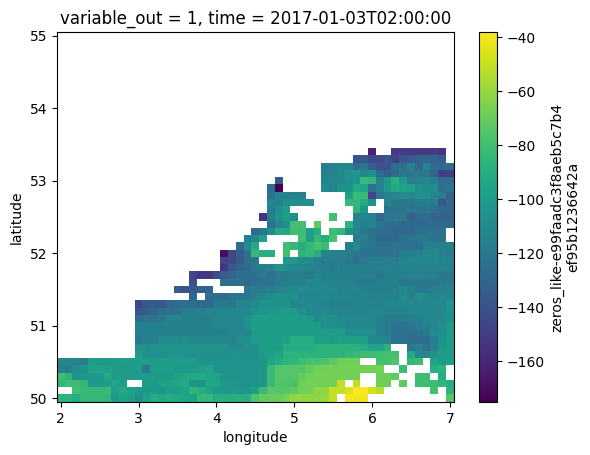

In [71]:
result1[:,:,1,98].plot()

In [28]:
template = xr.zeros_like(ds_ss['Rin'])
template = template.chunk({'time': 1})

In [29]:
ds_ss['Rin']

<xarray.DataArray 'Rin' (time: 2000, latitude: 51, longitude: 51)>
dask.array<getitem, shape=(2000, 51, 51), dtype=float32, chunksize=(2000, 51, 51), chunktype=numpy.ndarray>
Coordinates:
  * longitude    (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude     (latitude) float64 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * time         (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-02-11T16:...
    crs          int64 0
    spatial_ref  int64 0

In [60]:
def aa(ds_ss, hc, ds_Vcmo, landcover, IGBP_table, training_testing_append, path_model):
    x = ds_ss
    y = hc.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size) #如果和动态变量一样放进ds_ss里显示为一些离散的点，不知道为什么，所以静态变量放在时间循环外面
    z = ds_Vcmo.to_numpy().reshape(1, hc.latitude.size*hc.longitude.size)
    i = landcover_to_igbp(landcover, IGBP_table, training_testing_append)
    model = load_model(path_model)
    return x.isel(variable=1).drop_vars("variable")
    # return test

In [62]:
y = xr.map_blocks(
    aa,#
    ds_ss.to_array().chunk({'time': 1, 'variable': 10}),
    args=[hc.chunk().squeeze(), ds_Vcmo.chunk().squeeze(), landcover.squeeze()],
    kwargs={"IGBP_table":IGBP_table, "training_testing_append":data, "path_model":'/gpfs/work1/0/einf2480/global_data_Qianqian/RF_train/RFLEH-LAI-hc-CO2-SSM-Vcmo-IGBP_multi7_1core_snellius0629.pkl'}, #
    template = template, 
)

In [ ]:
re = y.compute()

In [65]:
re

<xarray.DataArray 'Rin' (time: 2000, latitude: 51, longitude: 51)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [268.96139526, 271.4916687 , 273.89526367, ..., 261.37081909,
         262.00332642, 262.76220703],
        [269.21444702, 271.87112427, 274.527771  , ..., 264.53359985,
         264.78637695, 265.29251099],
        [271.87112427, 274.90750122, 277.56417847, ..., 267.31668091,
         267.1902771 , 266.81054688]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
...
        [306.40054321, 308.3236084 , 309.22109985, ..., 292.68304443,
         292.68276978, 292.68304443],
        [306.14416504, 307.93890381, 308.96472168, ..., 295.88806152,
         296.1444397 , 296.27249146],
        [304.99026489, 306.40026855, 307.55444336, ..., 300.50305176,
         300.63137817, 301.01611328]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [303.25971985, 304.99028015, 306.14416504, ..., 294.99069214,
         294.34944153, 293.6444397 ],
        [303.70819092, 305.24667358, 306.27235413, ..., 297.68278503,
         297.10583496, 296.5930481 ],
        [303.77249146, 304.99028015, 306.01583862, ..., 301.72097778,
         301.27249146, 300.95195007]]])
Coordinates:
  * longitude    (longitude) float64 2.0 2.1 2.2 2.3 2.4 ... 6.6 6.7 6.8 6.9 7.0
  * latitude     (latitude) float64 55.0 54.9 54.8 54.7 ... 50.3 50.2 50.1 50.0
  * time         (time) datetime64[ns] 2017-01-01T01:00:00 ... 2017-02-11T16:...
    crs          int64 0
    spatial_ref  int64 0

In [66]:
y = xr.map_blocks(
    lambda x, y, z, i, IGBP_table, training_testing_append, model: x.isel(variable=1).drop_vars("variable"),#
    ds_ss.to_array().chunk({'time': 1, 'variable': 10}),
    args=[hc.chunk().squeeze(), ds_Vcmo.chunk().squeeze(), landcover.squeeze()],
    kwargs={"IGBP_table":IGBP_table, "training_testing_append":data, "path_model":rfLEHmulti}, #
    template = template, 
)

In [ ]:
y.compute()

In [ ]:
result2 = predictFlux(ds_ss.to_array().isel(time=slice(0,1)), hc.squeeze(), ds_Vcmo.squeeze(), landcover.squeeze(), IGBP_table, training_testing_append, rfLEHmulti)

In [223]:
# ds_ss = ds_ss.to_array()
result = xr.zeros_like(ds_ss)
features_arr = ds_ss.stack(dim=("time","longitude","latitude")).transpose()
features_arr

<xarray.Dataset>
Dimensions:      (dim: 3862485)
Coordinates:
    crs          int64 0
    spatial_ref  int64 0
  * dim          (dim) object MultiIndex
  * time         (dim) datetime64[ns] 2011-03-01T01:00:00 ... 2011-03-31T23:0...
  * longitude    (dim) float64 20.0 20.0 20.0 20.0 20.0 ... 25.0 25.0 25.0 25.0
  * latitude     (dim) float64 65.0 64.9 64.8 64.7 64.6 ... 60.3 60.2 60.1 60.0
Data variables:
    Rin          (dim) float32 dask.array<chunksize=(3862485,), meta=np.ndarray>
    Rli          (dim) float32 dask.array<chunksize=(3862485,), meta=np.ndarray>
    p            (dim) float32 dask.array<chunksize=(3862485,), meta=np.ndarray>
    Ta           (dim) float32 dask.array<chunksize=(3862485,), meta=np.ndarray>
    ea           (dim) float32 dask.array<chunksize=(3862485,), meta=np.ndarray>
    u            (dim) float32 dask.array<chunksize=(3862485,), meta=np.ndarray>
    Precip_msr   (dim) float32 dask.array<chunksize=(3862485,), meta=np.ndarray>
    LAI          (dim) float64 dask.array<chunksize=(3862485,), meta=np.ndarray>
    CO2          (dim) float64 dask.array<chunksize=(3862485,), meta=np.ndarray>
    SSM          (dim) float64 dask.array<chunksize=(3862485,), meta=np.ndarray>

In [132]:
np.zeros(ds_ss.latitude.size ds_ss.longitude.size)

(2601,)

In [127]:
lai

<xarray.DataArray 'LAI' (time: 1009, latitude: 51, longitude: 51)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan, 1.25161815, 1.29069996, ..., 1.18381977,
                nan,        nan],
        [       nan, 0.75076133, 0.99247164, ..., 1.76932931,
         1.7632792 ,        nan],
        ...,
        [       nan, 1.05503809, 0.42392796, ..., 1.53469443,
         1.00339913,        nan],
        [       nan, 1.07308602, 0.83268845, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan, 1.25168768, 1.29072857, ..., 1.18409891,
                nan,        nan],
        [       nan, 0.75083506, 0.99265715, ..., 1.76946683,
         1.76341056,        nan],
...
        [       nan, 1.09595667, 0.46935362, ..., 1.57476958,
         1.10821932,        nan],
        [       nan, 1.24216909, 0.91574324, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan, 1.34386921, 1.32418609, ..., 1.22694945,
                nan,        nan],
        [       nan, 0.79225338, 1.4719975 , ..., 1.91145825,
         2.04081988,        nan],
        ...,
        [       nan, 1.09597743, 0.46940333, ..., 1.57480824,
         1.10832047,        nan],
        [       nan, 1.24228907, 0.9158172 , ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * longitude  (longitude) float32 20.0 20.1 20.2 20.3 ... 24.7 24.8 24.9 25.0
  * latitude   (latitude) float32 65.0 64.9 64.8 64.7 ... 60.3 60.2 60.1 60.0
    crs        int64 0
  * time       (time) datetime64[ns] 2011-03-10 ... 2011-03-31
Attributes:
    long_name:      Leaf Area Index 1km
    grid_mapping:   crs
    standard_name:  leaf_area_index
    units:          1
    valid_range:    [    0 65530]

In [124]:
IGBP_all.iloc[:,0].to_numpy().shape

(2601,)

In [122]:
IGBP_all

,IGBP_veg_long1,IGBP_veg_long2,IGBP_veg_long3,IGBP_veg_long4,IGBP_veg_long5,IGBP_veg_long6,IGBP_veg_long7,IGBP_veg_long8,IGBP_veg_long9,IGBP_veg_long10,IGBP_veg_long11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [121]:
ds_Vcmo

<xarray.DataArray (band: 1, y: 51, x: 51)>
[2601 values with dtype=float32]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 65.0 64.9 64.8 64.7 64.6 ... 60.4 60.3 60.2 60.1 60.0
  * x        (x) float64 20.0 20.1 20.2 20.3 20.4 ... 24.6 24.7 24.8 24.9 25.0
Attributes:
    transform:      (0.1, 0.0, 19.95, 0.0, -0.1, 65.05)
    crs:            +init=epsg:4326
    res:            (0.1, 0.1)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area

In [120]:
hc

<xarray.DataArray 'band_data' (band: 1, latitude: 51, longitude: 51)>
[2601 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * longitude    (longitude) float64 20.0 20.1 20.2 20.3 ... 24.7 24.8 24.9 25.0
  * latitude     (latitude) float64 65.0 64.9 64.8 64.7 ... 60.3 60.2 60.1 60.0
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:  Area
    long_name:      band_data

In [6]:
result_LE, result_H = Read_LSFs_Estimated_fluxes(1, rfLEHmulti)

<class 'str'>


/tmp/ipykernel_390/2157534080.py:100: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_SSM = xr.open_rasterio(path_SSM, engine="rasterio")

KeyboardInterrupt



In [185]:
result_LE, result_H = Read_LSFs_Estimated_fluxes(1, rfLEHmulti)

<class 'str'>


/tmp/ipykernel_431/1005322504.py:100: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_SSM = xr.open_rasterio(path_SSM, engine="rasterio")
/tmp/ipykernel_431/1005322504.py:122: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds_Vcmo = xr.open_rasterio("/data/private/DL/datadownload/"+year+"/vcmax/TROPOMI_Vmax_Tg_mean10km.tif", engine="rasterio")
/tmp/ipykernel_431/1005322504.py:127: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  landcover = xr.open_rasterio(path_landcover, engine="rasterio")


read data, That took 220.8619101047516 seconds
2011-03-11T10:00:00.000000000
<class 'numpy.ndarray'>
input data orgainze took 4.833735466003418 seconds
1 timestep took 0.013894796371459961 seconds
assign values took 0.0035610198974609375 seconds
2011-03-11T10:30:00.000000000


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<class 'numpy.ndarray'>
input data orgainze took 4.835605621337891 seconds
1 timestep took 0.009560823440551758 seconds
assign values took 0.0033538341522216797 seconds
2011-03-11T11:00:00.000000000


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<class 'numpy.ndarray'>
input data orgainze took 4.767719984054565 seconds
1 timestep took 0.009716272354125977 seconds
assign values took 0.003357410430908203 seconds
2011-03-11T11:30:00.000000000


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<class 'numpy.ndarray'>
input data orgainze took 4.829821586608887 seconds
1 timestep took 0.009194135665893555 seconds
assign values took 0.0033087730407714844 seconds
That took 19.323222398757935 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [174]:
starttime = time.time()
for count_i,t in enumerate(all_resample.time.to_numpy()[500:505]):
    starttime1 = time.time()
    estimated_LEH = rfLEHmulti_parallel.predict(features_arr)
    estimated_LEH[invalid_index] = np.nan
    LEH_map = estimated_LEH
    LEH_map = estimated_LEH.reshape(ds_ss.latitude.size, ds_ss.longitude.size,2)
    result_LE[count_i, ::] = LEH_map[:,:,0]
    result_H[count_i, ::] = LEH_map[:,:,1]
    print('1 timestep took {} seconds'.format(time.time() - starttime1))  

print('That took {} seconds'.format(time.time() - starttime))     
    

1 timestep took 0.028702497482299805 seconds
1 timestep took 0.027823925018310547 seconds
1 timestep took 0.02513885498046875 seconds
1 timestep took 0.02736663818359375 seconds
1 timestep took 0.025599956512451172 seconds
That took 0.13562345504760742 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not h

In [175]:
starttime = time.time()
for count_i,t in enumerate(all_resample.time.to_numpy()[500:505]):
    starttime1 = time.time()
    estimated_LEH = rfLEHmulti.predict(features_arr)
    estimated_LEH[invalid_index] = np.nan
    LEH_map = estimated_LEH
    LEH_map = estimated_LEH.reshape(ds_ss.latitude.size, ds_ss.longitude.size,2)
    result_LE[count_i, ::] = LEH_map[:,:,0]
    result_H[count_i, ::] = LEH_map[:,:,1]
    print('1 timestep took {} seconds'.format(time.time() - starttime1))  

print('That took {} seconds'.format(time.time() - starttime))     
    

1 timestep took 0.016613245010375977 seconds
1 timestep took 0.012269973754882812 seconds
1 timestep took 0.012846231460571289 seconds
1 timestep took 0.011864423751831055 seconds
1 timestep took 0.01099848747253418 seconds
That took 0.06540894508361816 seconds


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not h

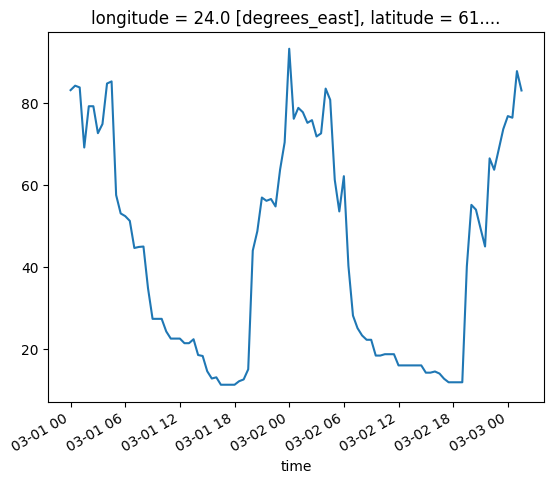

In [21]:
result_LE.sel(longitude=24,latitude=61, method='nearest').plot()

In [141]:
# export but not adjustable
variable = result_LE
variable.to_netcdf("/data/private/DL/Kratzert/10kmfluxesdata/testtime4.nc",mode='w', format='NETCDF4') #

In [371]:
seconds_since_epoch = (variable.time.values.astype('datetime64[s]') - np.datetime64('1970-01-01T00:00:00Z')).astype(int)
seconds_since_epoch

/tmp/ipykernel_1008/79878215.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  seconds_since_epoch = (variable.time.values.astype('datetime64[s]') - np.datetime64('1970-01-01T00:00:00Z')).astype(int)


array([1298937600, 1298939400, 1298941200, ..., 1301608800, 1301610600,
       1301612400])

In [394]:
# method suggested by Bas, flexible
from netCDF4 import Dataset

lat = variable.latitude.values # the list of latitudes
lon = variable.longitude.values #
data = variable.values # the soil moisture data
workdir = '/data/private/DL/Kratzert/10kmfluxesdata/'

filename_out = '/data/private/DL/Kratzert/10kmfluxesdata/mymodel33.nc'
# Create a new empty netCDF file, in NETCDF3_CLASSIC format (more formats are available)
nc = Dataset(filename_out, mode='w', format='NETCDF3_CLASSIC')

# Create the dimensions, as required by netCDF
nc.createDimension('x', size=len(lon)) # instead of x,y you can use lon,lat as dimension names
nc.createDimension('y', size=len(lat))
nc.createDimension('time', None)

# Create the variables, as required by netCDF
var_x = nc.createVariable('x', 'float64', ('x')) # instead of x,y you can use lon,lat as variable names
var_y = nc.createVariable('y', 'float64', ('y'))
var_t = nc.createVariable('time', 'float64', ('time',))

# Fill the x, y, time variables with values
var_x[:] = lon
var_y[:] = lat
# var_t[:] = variable.time.values
# var_t.setncattr('units', 'seconds since 1970-01-01 00:00:00') # this is only a description; you can change it
# var_t.setncattr('calendar', 'standard')

# the actual data to be stored in the netcdf (soilmoisture?)
var = nc.createVariable('LE', 'float32', ('time','y','x'))
var[:] = data # if 'data' does not have the same structure as the one created here (time, y, x) you may need to transpose

# write the time as last
var_t_length = data.shape[0] # the number of timesteps

var_t[:] = seconds_since_epoch
# var_t[:] = [i*3600 for i in range(var_t_length)] # this is a simple computation; you may have a list of times, or you may want to compute the 'unix' time
nc.close()

In [397]:
def export_to_nc(output_data,output_path):
    # method suggested by Bas, flexible
    from netCDF4 import Dataset

    lat = output_data.latitude.values # the list of latitudes
    lon = output_data.longitude.values #
    data = output_data.values # the soil moisture data

    
    # Create a new empty netCDF file, in NETCDF3_CLASSIC format (more formats are available)
    nc = Dataset(output_path, mode='w', format='NETCDF3_CLASSIC')

    # Create the dimensions, as required by netCDF
    nc.createDimension('x', size=len(lon)) # instead of x,y you can use lon,lat as dimension names
    nc.createDimension('y', size=len(lat))
    nc.createDimension('time', None)

    # Create the variables, as required by netCDF
    var_x = nc.createVariable('x', 'float64', ('x')) # instead of x,y you can use lon,lat as variable names
    var_y = nc.createVariable('y', 'float64', ('y'))
    var_t = nc.createVariable('time', 'float64', ('time',))

    # Fill the x, y, time variables with values
    var_x[:] = lon
    var_y[:] = lat
    # var_t[:] = variable.time.values
    # var_t.setncattr('units', 'seconds since 1970-01-01 00:00:00') # this is only a description; you can change it
    # var_t.setncattr('calendar', 'standard')

    # the actual data to be stored in the netcdf (soilmoisture?)
    var = nc.createVariable('LE', 'float32', ('time','y','x'))
    var[:] = data # if 'data' does not have the same structure as the one created here (time, y, x) you may need to transpose

    # write the time as last
    var_t_length = data.shape[0] # the number of timesteps
    seconds_since_epoch = (output_data.time.values.astype('datetime64[s]') - np.datetime64('1970-01-01T00:00:00Z')).astype(int)
    var_t[:] = seconds_since_epoch
    # var_t[:] = [i*3600 for i in range(var_t_length)] # this is a simple computation; you may have a list of times, or you may want to compute the 'unix' time
    nc.close()

In [398]:
export_to_nc(variable, '/data/private/DL/Kratzert/10kmfluxesdata/mymodel35.nc')


/tmp/ipykernel_1008/4192254170.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  seconds_since_epoch = (output_data.time.values.astype('datetime64[s]') - np.datetime64('1970-01-01T00:00:00Z')).astype(int)
